In [175]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [239]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import layers, Model
import os
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,GRU
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [177]:
import unidecode

In [178]:
df = pd.read_csv("letras_forro.csv")

In [204]:
batch_size = 64
rnn_neurons = 1026

In [205]:
text = ''
for letra in df['Album'].unique():
  aux_text = letra.lower()
  text += aux_text

In [242]:
chars = sorted(list(set(text)))
print(f"Palavras Distintas: {len(chars)}")

Palavras Distintas: 94


In [208]:
max_len = 20 # É evidar redudância
step = 3
input_chars = []
output_chars = []

In [209]:
for i in range(0, len(text) - max_len, step):
    input_chars.append(text[i : i + max_len])
    output_chars.append(text[i + max_len])

In [247]:
print("Número de Sequências:", len(input_chars))
print("Palavra entrada  (input_chars)  --->   Saída (next_char) ")

for i in range(5):
  print(f"Palavra Completa {input_chars[i] + next_char[i]}")
  print( f"Entrada {input_chars[i]} -> {next_char[i]}")
  print()


Número de Sequências: 583645
Palavra entrada  (input_chars)  --->   Saída (next_char) 
Palavra Completa a casa que vovô morou
Entrada a casa que vovô moro -> u

Palavra Completa asa que vovô morou o 
Entrada asa que vovô morou o ->  

Palavra Completa  que vovô morou o meu
Entrada  que vovô morou o me -> u

Palavra Completa e vovô morou o meu pa
Entrada e vovô morou o meu p -> a

Palavra Completa ovô morou o meu pai h
Entrada ovô morou o meu pai  -> h



In [211]:
# Criação deu m conjunto de dados de treinamento
X_train_ds_raw=tf.data.Dataset.from_tensor_slices(input_chars)
y_train_ds_raw=tf.data.Dataset.from_tensor_slices(next_char)

In [213]:
def normalize(input_data):
    lowercase     = tf.strings.lower(input_data) #deixa palavras lower_case
    stripped_num  = tf.strings.regex_replace(lowercase, "[\d-]", " ") #remove numeros
    stripped_punc =tf.strings.regex_replace(stripped_num, "[%s]" % re.escape(string.punctuation), "")   #remove pontuacao 
    return stripped_punc

def char_split(input_data):
  return tf.strings.unicode_split(input_data, 'UTF-8') #split de cada palavra em unicode


In [214]:
# Model constants.
max_features = 96           # Numero depalavras distntas
embedding_dim = 10             # Embedding layer output dimension
sequence_length = max_len 

In [215]:
vectorize_layer = TextVectorization(
    standardize=normalize,
    max_tokens=max_features,
    split=char_split, 
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [216]:
vectorize_layer.adapt(X_train_ds_raw.batch(batch_size))

In [251]:
print("Tamanho do Vocabulario: ", len(vectorize_layer.get_vocabulary()))

Tamanho do Vocabulario:  60


In [218]:
def vectorize_text(text):
  text = tf.expand_dims(text, -1)
  return tf.squeeze(vectorize_layer(text))

In [219]:

X_train_ds = X_train_ds_raw.map(vectorize_text)
y_train_ds = y_train_ds_raw.map(vectorize_text)

X_train_ds.element_spec, y_train_ds.element_spec

(TensorSpec(shape=(20,), dtype=tf.int64, name=None),
 TensorSpec(shape=(20,), dtype=tf.int64, name=None))

In [220]:
y_train_ds=y_train_ds.map(lambda x: x[0])

In [221]:
train_ds =  tf.data.Dataset.zip((X_train_ds,y_train_ds))


In [223]:
def decode_sequence (encoded_sequence):
  deceoded_sequence=[]
  for token in encoded_sequence:
    deceoded_sequence.append(vectorize_layer.get_vocabulary()[token])
  sequence= ''.join(deceoded_sequence)
  return sequence

In [224]:
AUTOTUNE = tf.data.AUTOTUNE #reduz o tempo de processamento
train_ds = train_ds.shuffle(buffer_size=512).batch(batch_size, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)

# Sampling

Na geração de texto, a técnica de sampling, é utilizada para escolher o próximo token de acordo com a probabilidade.

Ou seja, dada um conjunto de tokens, para cada entrada é necessário selecionar o próximo token de acordo com a distribuição.
* **Greedy Search**:
Seleciona a partir de uma palavra a próxima, cujo a mesma tenha uma alta probabilidade,
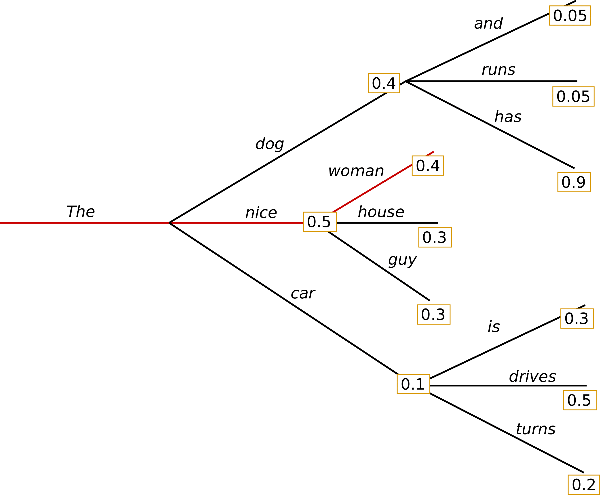

* **Temperature Sampling**:
Inspirada na termodinamica, onde alta temperatura significa que estados de baixa energia são mais prováveis ​​de serem encontrados. Nos modelos de probabilidade, os logits desempenham o papel de energia e podemos implementar a amostragem de temperatura dividindo os logits pela temperatura antes de alimentá-los no softmax e obter nossas probabilidades de amostragem.
Temperaturas mais baixas tornam o modelo cada vez mais confiante em suas principais escolhas, enquanto temperaturas maiores que 1 diminuem a confiança. A temperatura 0 é equivalente à probabilidade argmax/max, enquanto a temperatura infinita corresponde a uma amostragem uniforme.

* **Top K Sampling**:
Amostragem top k significa classificar por probabilidade e zerar as probabilidades para qualquer coisa abaixo do k'th token. Parece melhorar a qualidade removendo a cauda e tornando menos provável que saia do tópico. Mas, em alguns casos, realmente há muitas palavras das quais podemos amostrar razoavelmente (distribuição ampla abaixo), e em alguns casos não há (distribuição restrita abaixo).

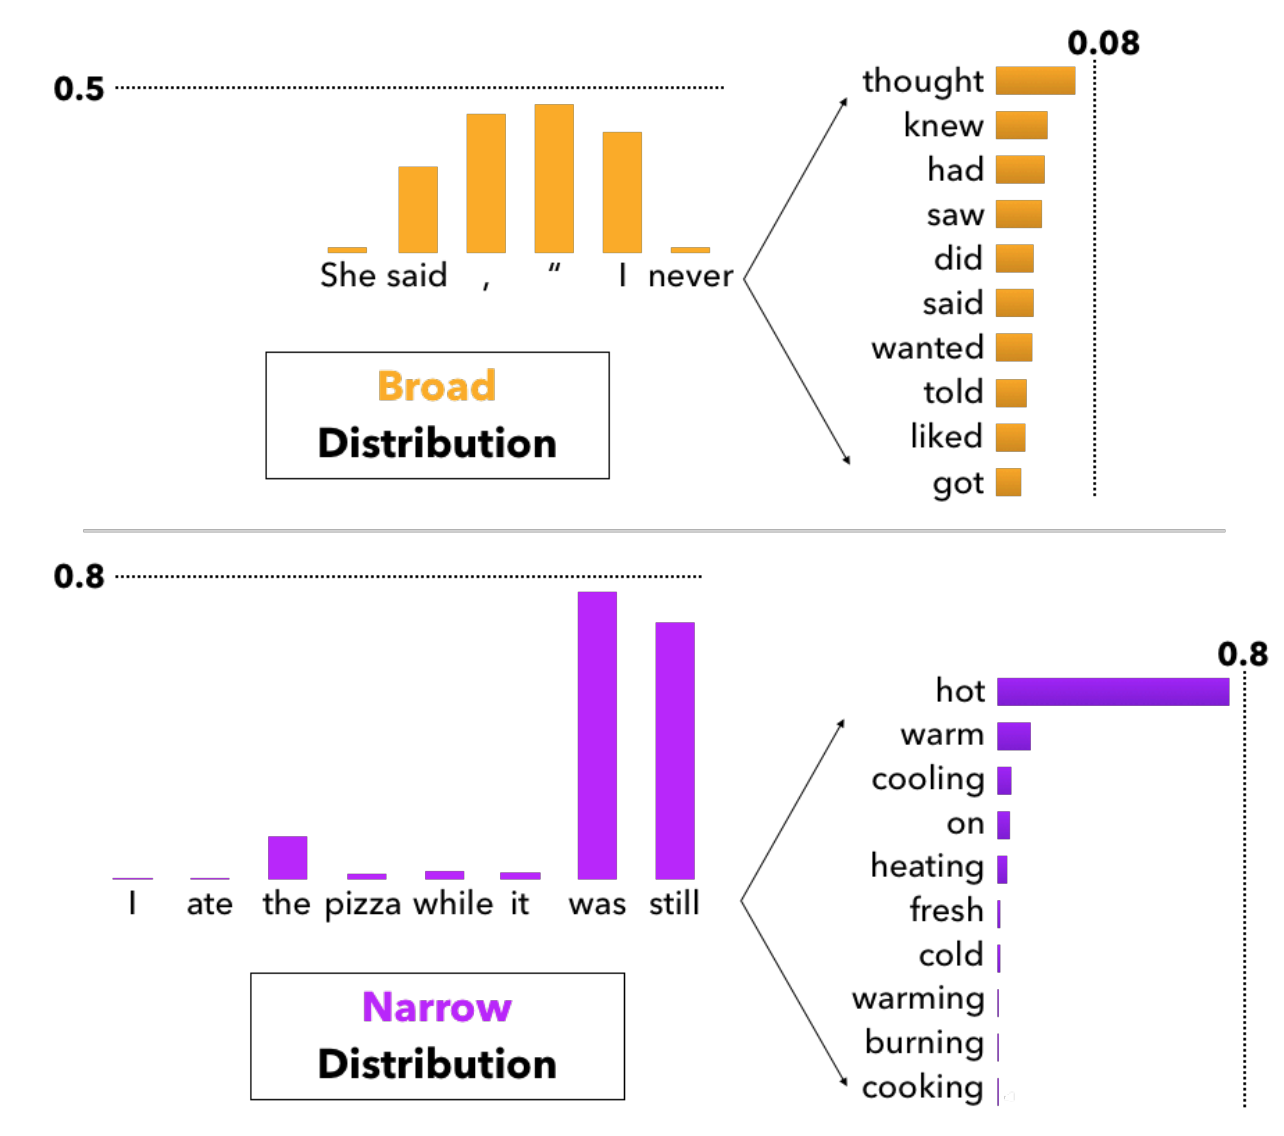

In [228]:
def softmax(z):
  return np.exp(z)/sum(np.exp(z))

def greedy_search(conditional_probability):
  return (np.argmax(conditional_probability))

def temperature_sampling (conditional_probability, temperature=1.0):
  conditional_probability = np.asarray(conditional_probability).astype("float64")
  conditional_probability = np.log(conditional_probability) / temperature
  reweighted_conditional_probability = softmax(conditional_probability)
  probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
  return np.argmax(probas)

def top_k_sampling(conditional_probability, k):
  top_k_probabilities, top_k_indices= tf.math.top_k(conditional_probability, k=k, sorted=True)
  top_k_probabilities= np.asarray(top_k_probabilities).astype("float32")
  top_k_probabilities= np.squeeze(top_k_probabilities)
  top_k_indices = np.asarray(top_k_indices).astype("int32")
  top_k_redistributed_probability = softmax(top_k_probabilities)
  top_k_redistributed_probability = np.asarray(top_k_redistributed_probability).astype("float32")
  sampled_token = np.random.choice(np.squeeze(top_k_indices), p=top_k_redistributed_probability)
  return sampled_token


In [229]:
inputs = tf.keras.Input(shape=(sequence_length), dtype="int64")
x = layers.Embedding(max_features, embedding_dim)(inputs) #Num de palavras distintas
x = layers.Dropout(0.5)(x) #Camada de Dropout, evitar overfitting
x = layers.LSTM(rnn_neurons, return_sequences=True)(x) #LSTM RNN_NEUROS = 1026, return_sequences, ele da output da palavra
predictions=  layers.Dense(max_features, activation='softmax')(x)
model_LSTM = tf.keras.Model(inputs, predictions,)

In [230]:
model_LSTM.compile(loss='sparse_categorical_crossentropy', 
                   optimizer='adam', metrics=['accuracy'])
print(model_LSTM.summary())

Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding_8 (Embedding)     (None, 20, 16)            1536      
                                                                 
 dropout_2 (Dropout)         (None, 20, 16)            0         
                                                                 
 lstm_2 (LSTM)               (None, 20, 1026)          4280472   
                                                                 
 flatten_2 (Flatten)         (None, 20520)             0         
                                                                 
 dense_8 (Dense)             (None, 96)                1970016   
                                                                 
Total params: 6,252,024
Trainable params: 6,252,024
Non-

In [231]:
history = model_LSTM.fit(train_ds, epochs=10) 

Epoch 1/10
9119/9119 [==============================] - 138s 15ms/step - loss: 2.1883 - accuracy: 0.3608
Epoch 2/10
9119/9119 [==============================] - 135s 15ms/step - loss: 1.7464 - accuracy: 0.4746
Epoch 3/10
9119/9119 [==============================] - 137s 15ms/step - loss: 1.5700 - accuracy: 0.5227
Epoch 4/10
9119/9119 [==============================] - 136s 15ms/step - loss: 1.4769 - accuracy: 0.5481
Epoch 5/10
9119/9119 [==============================] - 136s 15ms/step - loss: 1.4077 - accuracy: 0.5669
Epoch 6/10
9119/9119 [==============================] - 138s 15ms/step - loss: 1.3521 - accuracy: 0.5823
Epoch 7/10
9119/9119 [==============================] - 137s 15ms/step - loss: 1.3043 - accuracy: 0.5955
Epoch 8/10
9119/9119 [==============================] - 137s 15ms/step - loss: 1.2611 - accuracy: 0.6078
Epoch 9/10
9119/9119 [==============================] - 137s 15ms/step - loss: 1.2210 - accuracy: 0.6186
Epoch 10/10
9119/9119 [==============================] 

In [252]:
history.history

{'accuracy': [0.36083313822746277,
  0.4745500385761261,
  0.5227152705192566,
  0.5481326580047607,
  0.566891610622406,
  0.5823349356651306,
  0.5954583287239075,
  0.6078208684921265,
  0.6185779571533203,
  0.6294035911560059],
 'loss': [2.1882927417755127,
  1.7463668584823608,
  1.5700008869171143,
  1.4769190549850464,
  1.4077115058898926,
  1.3520991802215576,
  1.304343342781067,
  1.2610673904418945,
  1.2209974527359009,
  1.1825414896011353]}

In [232]:
def decode_sequence (encoded_sequence):
  deceoded_sequence=[]
  for token in encoded_sequence:
    deceoded_sequence.append(vectorize_layer.get_vocabulary()[token])
  sequence= ''.join(deceoded_sequence)
 
  return sequence


In [254]:
def generate_text(model, seed_original, step):
    seed= vectorize_text(seed_original)
    print(f"A palavra foi {seed_original}")
    decode_sequence(seed.numpy().squeeze())
    

    seed= vectorize_text(seed_original).numpy().reshape(1,-1)
   
    generated_greedy_search = (seed)
    for i in range(step):
      predictions=model.predict(seed)
      next_index= greedy_search(predictions.squeeze())
      generated_greedy_search = np.append(generated_greedy_search, next_index)
      seed= generated_greedy_search[-sequence_length:].reshape(1,sequence_length)
    print("Texto gerado pelo Greedy: ")
    decode_sequence(generated_greedy_search)

    print("Texto gerado pelo Temperature")
    for temperature in [0.2, 0.5, 0.7, 0.9, 1, 1.2]:
        print("\ttemperature: ", temperature)
        seed= vectorize_text(seed_original).numpy().reshape(1,-1)
        generated_temperature = (seed)
        for i in range(step):
            predictions=model.predict(seed)
            next_index = temperature_sampling(predictions.squeeze(), temperature)
            generated_temperature = np.append(generated_temperature, next_index)
            seed= generated_temperature[-sequence_length:].reshape(1,sequence_length)
        decode_sequence(generated_temperature)

    print("Texto gerado pelo Top K:")
    for k in [2, 3, 4, 5]:
        print("\tTop-k: ", k)
        seed= vectorize_text(seed_original).numpy().reshape(1,-1)
        generated_top_k = (seed)
        for i in range(step):
            predictions=model.predict(seed)
            next_index = top_k_sampling(predictions.squeeze(), k)
            generated_top_k = np.append(generated_top_k, next_index)
            seed= generated_top_k[-sequence_length:].reshape(1,sequence_length)
        decode_sequence(generated_top_k)


In [255]:
generate_text(model_LSTM,"amo meu sertão", 250)

A palavra foi amo meu sertão
	 amo meu sertão
Texto gerado pelo Greedy: 
	 amo meu sertão de você e agora que eu te amo você me deu valor mais uma vez você me deixou na sua mão eu vou viver sempre que eu te amo mais eu vou viver sempre que eu te amo mais eu vou viver sempre que eu te amo mais eu vou viver sempre que eu te amo mais eu vou
Texto gerado pelo Temperature
	temperature:  0.2
	 amo meu sertão de você e agora que eu te amo e que eu vou fazer pra te amar como eu te amo tudo que eu vou fazer pra te amar eu te amo tudo que eu vou fazer pra trazer você não me esqueço e o meu pensamento é bom demais o que eu quero é você e a vida sem você eu v
	temperature:  0.5
	 amo meu sertão acreditar e a noite chegando sem você a distancia de mim com quem quiser viver assim se eu te dizer que te amava e não me deixe essa soridão me abraça não tem perder eu peço aprender a falta que eu não volto atrás de você me ligando sabe que você m
	temperature:  0.7
	 amo meu sertão m você eu vire lovando 

In [256]:
generate_text(model_LSTM,"me liga essa noite", 250)

A palavra foi me liga essa noite
	 me liga essa noite
Texto gerado pelo Greedy: 
	 me liga essa noite de mim te amo e que eu vou fazer pra te amar eu te amo tudo que eu vou fazer pra te amar eu te amo tudo que eu vou fazer pra te amar eu te amo tudo que eu vou fazer pra te amar eu te amo tudo que eu vou fazer pra te amar eu te amo tudo que eu vou fa
Texto gerado pelo Temperature
	temperature:  0.2
	 me liga essa noite de mim não do nome de mim te amo demais eu não volto atrás vou dizer que tudo foi logo me apaixonar você é difícil acende a minha vida é você porque vai ter que eu te prometo que eu vou fazer pra te amar eu te amo tudo e você está fora do meu peito
	temperature:  0.5
	 me liga essa noite não consigo ficar com você e quem não quero mais porque eu entende a minha vida é você por outro amor eu penso de amor eu não podia amar você me da com outros é em nada é a gente se amar vou ficar só você me quer mas eu te amo mais ninguém vai te a
	temperature:  0.7
	 me liga essa noite 

In [257]:
generate_text(model_LSTM,"noite de são joão", 250)

A palavra foi noite de são joão
	 noite de são joão
Texto gerado pelo Greedy: 
	 noite de são joão a minha vida é você porque você me deixou sem você eu vou viver sou eu vou viver sempre que eu te amo mais eu vou viver sempre que eu te amo mais eu vou viver sempre que eu te amo mais eu vou viver sempre que eu te amo mais eu vou viver sempre que e
Texto gerado pelo Temperature
	temperature:  0.2
	 noite de são joão a minha vida é você porque você me deixou sem parar dizendo que eu te peço pra você pode me acostumei a minha vida é você porque vai mais controla a solidão me levanta a dor de você e você me diga que eu te amo e que eu vou viver você me deixou na s
	temperature:  0.5
	 noite de são joão com você e a gente só ele tem um varor brigar sabe meu amor eu te dei uma vez você me deixou numa solidão me levar pra te amar você me deu bate falta aqui cai nem ai pra você e não é que eu fiz ficar você me leva pra te amar até o gato mais eu vou v
	temperature:  0.7
	 noite de são joão e a 

# Podemos Concluir que 

* Greedy Search:
  * é o método mais simples, pois ele seleciona a próxima letra (token), com a maior probabilidade;
  * Como mostra a palavra com maior probabilidade, temos um grande risco do modelo entrar em loop;

* Temperature Sampling:
 * Se a temperatura for 0, então é um Greedy Search, tornando os outputs previsiveis e repetitivos;
 * Com a maior temperatura, os textos se tornam mais randomicos, com temparaturas maiores que 1, ele gera novas palavras, tornando as análises mais engraçadas;

* Top k Sampling:
  * Em artigos o top k sampling, geralmente ele possui uma performance melhor do que outros métodos;
  * Como a nossa base de dados é pequena, comparada com outras da literatura, o modelo pode não sentir o impacto, visto que o Top - K, acaba trabalhando em torno da frequência;
  * Top-K acaba gerando palavras aleatorias;
